In [1]:
from maud.document.converters import MaudConverter
from docling.document_converter import DocumentConverter
from pathlib import Path

In [2]:
pdf_input_path = Path('../tests/data/wind_turbine.pdf')
doc_input_path = Path('../tests/data/maintenance_procedure_template.docx')
ppt_input_path = Path('../tests/data/functional_flight_checks.pptx')
xls_input_path = Path('../tests/data/equipment_maintenance_schedule.xlsx')
output_dir = Path('../data/output')

# Get an llm model using ChatDatabricks

In [45]:
w.secrets.get_secret("shm", "host").value

'aGh0cHM6Ly9hZGI='

In [ ]:
"https://adb-984752964297111.11.azuredatabricks.net/serving-endpoints"

In [54]:
workspace_url

'https://adb-984752964297111.11.azuredatabricks.net'

In [59]:
from openai import OpenAI
from databricks.sdk import WorkspaceClient
w = WorkspaceClient()

workspace_client = WorkspaceClient()
workspace_url = workspace_client.config.host
token = workspace_client.config.token

client = OpenAI(
  api_key=token,
  base_url=f"{workspace_url}/serving-endpoints",
)

client.chat.completions.create(
    model="shm_gpt_4o_mini",
    messages=[{"role": "user", "content": "What is the capital of France?"}],
)

ChatCompletion(id='chatcmpl-B32Y7xObT1ygJaQJczAHTd1i7GWcp', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The capital of France is Paris.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1740064483, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_b705f0c291', usage=CompletionUsage(completion_tokens=7, prompt_tokens=14, total_tokens=21, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0

In [58]:
image_url = "https://www.arsenal.com/sites/default/files/styles/large_16x9/public/images/saka-celeb-bayern.png?h=3c8f2bed&auto=webp&itok=Twjeu8tug"
response = client.chat.completions.create(
  model="shm_gpt_4o_mini",
  messages=[
    {"role": "user", 
    "content": [
                {"type": "text", "text": "which football team is this player belong to?"},
                {
                    "type": "image_url",
                    "image_url": {
                      "url": image_url
                    },
                },
            ],
    }
  ],
  temperature=0.0,
  max_tokens=150,
)

response.choices[0].message.content.strip()

'The player belongs to Arsenal Football Club.'

In [9]:
from docling.datamodel.base_models import InputFormat
from docling.document_converter import PdfFormatOption
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline
from maud.document.converters import MAUDPipelineOptions

converter = MaudConverter(
    input_path=pdf_input_path,
    output_dir=output_dir,
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=StandardPdfPipeline,
            pipeline_options=MAUDPipelineOptions(),
        )
    }
)

converter.convert()

2025-02-19 17:55:03,574 - MaudConverter - INFO - Converting document
2025-02-19 17:55:03,575 - MaudConverter - INFO - Conversion exists, reloading document
2025-02-19 17:55:03,575 - MaudConverter - INFO - Loading document


In [190]:
class TableDescriptionData(PictureDescriptionData):
    kind: Literal["description"] = "description"
    text: str
    provenance: str

class TableDescriptionModel(BaseEnrichmentModel):
    def __init__(self, enabled: bool = True):
        self.enabled = enabled  

    def is_processable(self, doc: DoclingDocument, element: NodeItem) -> bool:
        return self.enabled and isinstance(element, TableItem)
    
    def __call__(self, doc: DoclingDocument, element_batch: Iterable[NodeItem]) -> Iterable[Any]:
        if not self.enabled:
            return
        
        for element in element_batch:
            assert isinstance(element, TableItem)
            element.annotations.append(
                TableDescriptionData(
                    provenance="a llm model",
                    text="This is a dummy table description",
                )
            )
            yield element

class ExtendedPdfPipeline(StandardPdfPipeline):
    def __init__(self, pipeline_options: EnrichedPipelineOptions):
        super().__init__(pipeline_options)
        self.page_metadata_model = PageMetadataModel(pipeline_options.describe_pages)

        self.enrichment_pipe.append(
                TableDescriptionModel(
                    enabled=True
                )
            )

In [191]:
ext_doc_converter = ExtendedDocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=ExtendedPdfPipeline,
            pipeline_options=EnrichedPipelineOptions(),
        )
    }
)

res = ext_doc_converter.convert(pdf_input_path)

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf
INFO:docling.document_converter:Finished converting document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf in 8.23 sec.


{'self_ref': '#/tables/1',
 'parent': {'cref': '#/body'},
 'children': [],
 'content_layer': <ContentLayer.BODY: 'body'>,
 'label': <DocItemLabel.TABLE: 'table'>,
 'prov': [{'page_no': 6,
   'bbox': {'l': 30.002201080322266,
    't': 567.5298461914062,
    'r': 389.61492919921875,
    'b': 404.66058349609375,
    'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>},
   'charspan': (0, 0)}],
 'captions': [],
 'references': [],
 'footnotes': [],
 'image': {'mimetype': 'image/png',
  'dpi': 72,
  'size': {'width': 360.0, 'height': 163.0},
  'uri': AnyUrl('')},
 'data': {'table_cells': [{'bbox': None,
    'row_span': 1,
    'col_span': 1,
    'start_row_offset_idx': 0,
    'end_row_offset_idx': 1,
    'start_col_offset_idx': 0,
    'end_col_offset_idx': 1,
    'text': '',
    'column_header': False,
    'row_header': False,
    'row_section': False},
   {'bbox': {'l': 71.04000091552734,
     't': 558.8319702148438,
     'r': 296.7829895019531,
     'b': 548.4530029296875,
     'coord_or
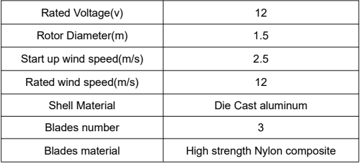

In [192]:
res.document.tables[1].model_dump()

In [103]:
page

PageItem(size=Size(width=419.5, height=595.25), image=None, page_no=1)

In [7]:
from docling_core.types.doc.document import PictureDescriptionData
from docling_core.types.doc import PictureClassificationData

## Try to work with page models
- Take pages
- Save images
- Make page classifications and annotations
- Capture lineage data

In [34]:


doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=EnrichedPipelineOptions(),
        )
    }
)
result = doc_converter.convert(pdf_input_path)

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf
INFO:docling.document_converter:Finished converting document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf in 7.85 sec.


In [35]:
from docling import parse_pdf

ImportError: cannot import name 'parse_pdf' from 'docling' (/Users/scott.mckean/Repos/multimodal-accelerator/.venv/lib/python3.11/site-packages/docling/__init__.py)

In [24]:
import logging
from pathlib import Path
from typing import Any, Iterable

from docling_core.types.doc import (
    DoclingDocument,
    NodeItem,
    PictureClassificationClass,
    PictureClassificationData,
    PictureItem,
)

from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.models.base_model import BaseEnrichmentModel
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline

class EnrichmentPipelineOptions(PdfPipelineOptions):
    describe_pages: bool = True
    describe_tables: bool = True
    classify_tables: bool = True
    describe_pictures: bool = True
    classify_pictures: bool = True

from typing import Literal
from docling_core.types.doc.document import BasePictureData

class PageDescriptionData(BasePictureData):
    """PictureDescriptionData."""

    kind: Literal["description"] = "description"
    text: str
    provenance: str




class PageDescriptionModel(BaseEnrichmentModel):
    def __init__(self, enabled: bool = True):
        self.enabled = enabled

    def is_processable(self, doc: DoclingDocument, element: NodeItem) -> bool:
        return self.enabled and isinstance(element, PageItem)
    
    def __call__(self, doc: DoclingDocument, element_batch: Iterable[NodeItem]) -> Iterable[Any]:
        if not self.enabled:
            return
        
        for page in element_batch:
            assert isinstance(element, PageItem)
            element.annotations.append(
                PageDescriptionData(
                    provenance="a llm model",
                    text="This is a page",
                )
            )

class PictureDescriptionModel(BaseEnrichmentModel):
    def __init__(self, enabled: bool = True):
        self.enabled = enabled

    def is_processable(self, doc: DoclingDocument, element: NodeItem) -> bool:
        return self.enabled and isinstance(element, PictureItem)

    def __call__(
        self, doc: DoclingDocument, element_batch: Iterable[NodeItem]
    ) -> Iterable[Any]:
        if not self.enabled:
            return

        for element in element_batch:
            assert isinstance(element, PictureItem)
            
            element.annotations.append(
                PictureDescriptionData(
                    provenance="a llm model",
                    text="This is a dummy description",
                )
            )

            yield element

class PictureClassifierModel(BaseEnrichmentModel):
    def __init__(self, enabled: bool = True):
        self.enabled = enabled

    def is_processable(self, doc: DoclingDocument, element: NodeItem) -> bool:
        return self.enabled and isinstance(element, PictureItem)

    def __call__(
        self, doc: DoclingDocument, element_batch: Iterable[NodeItem]
    ) -> Iterable[Any]:
        if not self.enabled:
            return

        for element in element_batch:
            assert isinstance(element, PictureItem)

            element.annotations.append(
                PictureClassificationData(
                    provenance="example_classifier-0.0.1",
                    predicted_classes=[
                        PictureClassificationClass(class_name="dummy", confidence=0.42)
                    ],
                )
            )
            
            yield element

class EnrichmentPipeline(StandardPdfPipeline):
    def __init__(self, pipeline_options: EnrichmentPipelineOptions):
        super().__init__(pipeline_options)
        self.pipeline_options: pipeline_options

        self.enrichment_pipe = [
            PictureClassifierModel(pipeline_options.classify_pictures),
            PictureDescriptionModel(pipeline_options.describe_pictures),
            PageDescriptionModel(pipeline_options.describe_pages)
        ]

    def process_document(self, doc: DoclingDocument) -> DoclingDocument:
        for model in self.enrichment_pipe:
            model(doc, doc.pages)
        return doc

    @classmethod
    def get_default_options(cls) -> EnrichmentPipelineOptions:
        return EnrichmentPipelineOptions()

logging.basicConfig(level=logging.INFO)



In [25]:
doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=EnrichmentPipeline,
            pipeline_options=pipeline_options,
        )
    }
)
result = doc_converter.convert(pdf_input_path)

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf
INFO:docling.document_converter:Finished converting document 92ab18cd-55d7-5c30-a347-2369dd751f74.pdf in 8.16 sec.


self_ref='#/pictures/0' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.PICTURE: 'picture'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=101.35415649414062, t=483.56976318359375, r=317.908935546875, b=418.9146728515625, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))] captions=[] references=[] footnotes=[] image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=433.0, height=130.0), uri=AnyUrl('')) annotations=[PictureClassificationData(kind='classification', provenance='example_classifier-0.0.1', predicted_classes=[PictureClassificationClass(class_name='dummy', confidence=0.42)]), PictureDescriptionData(kind='description', text='This is a dummy description', provenance='a llm model')]
self_ref='#/texts/0' parent=RefItem(cref='#/body') children=[] content_layer=<ContentLayer.BODY: 'body'> label=<DocItemLabel.TEXT: 'text'> prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=55.68000030517578, t=391
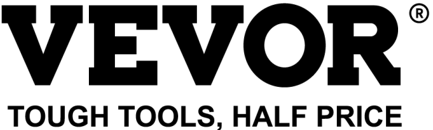
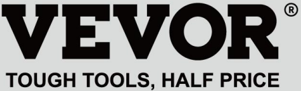
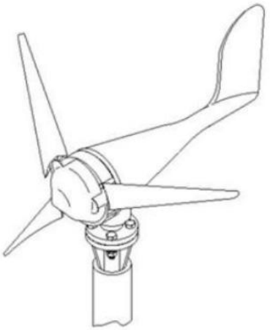
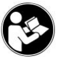
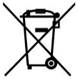
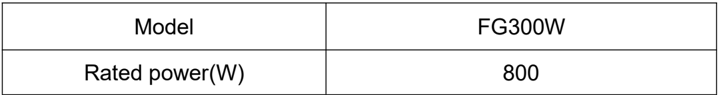
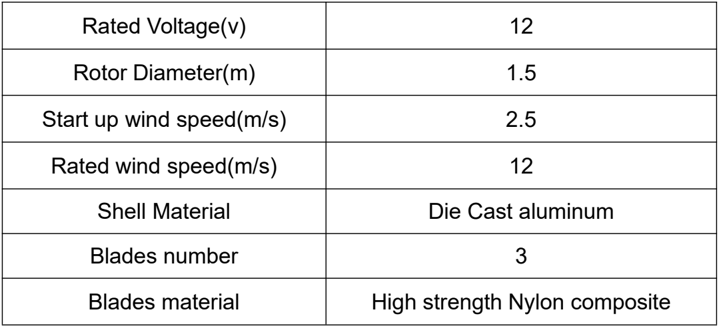
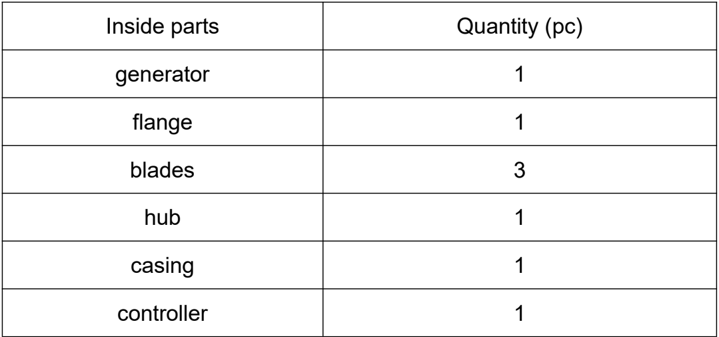
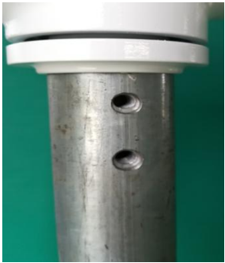
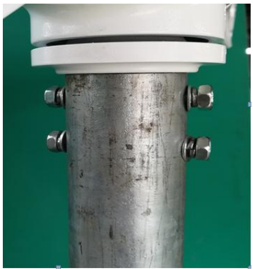
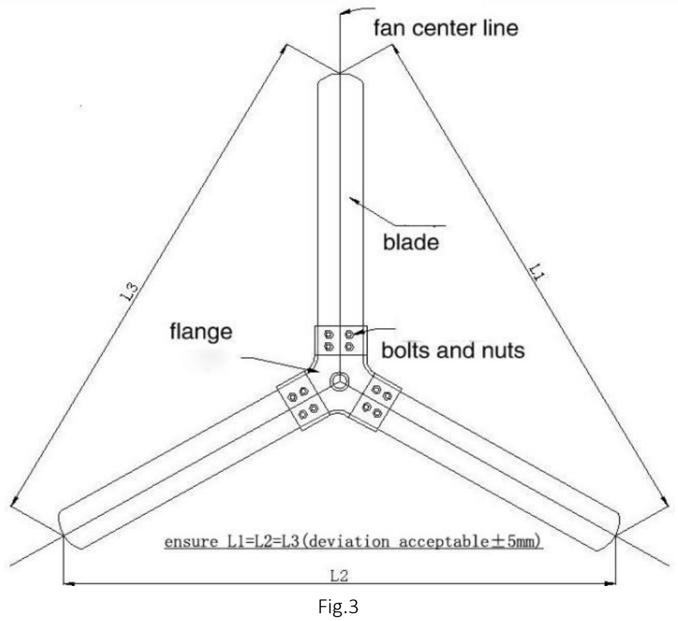
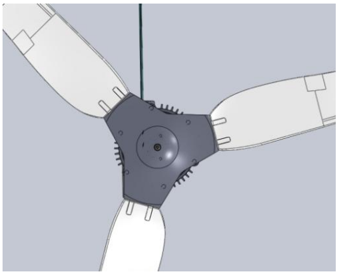
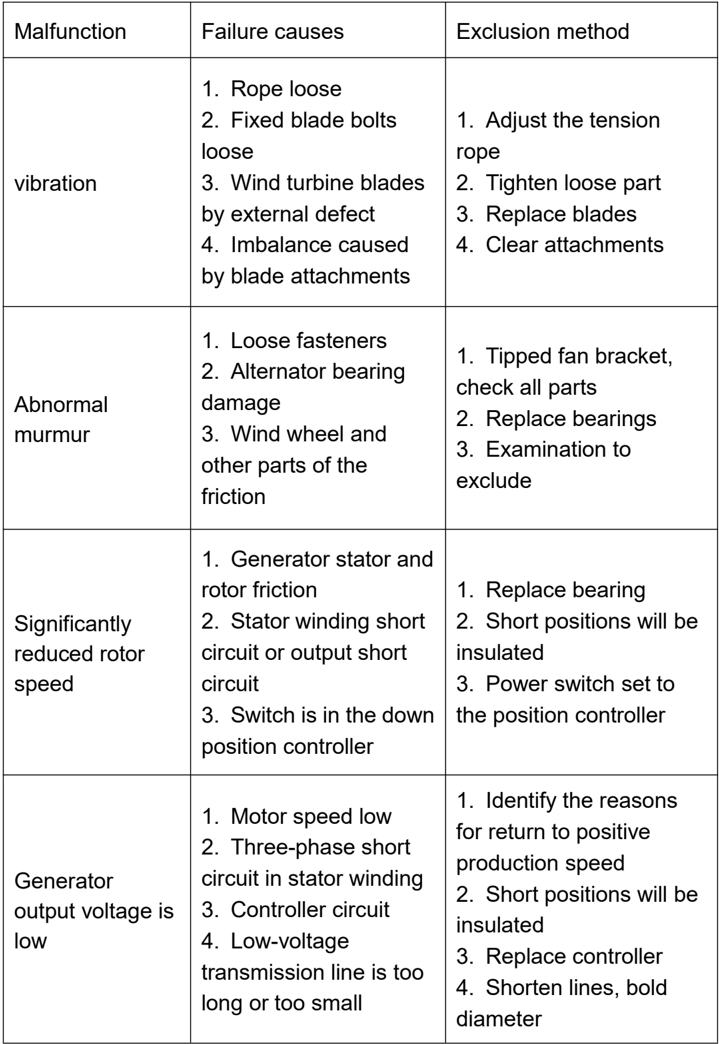
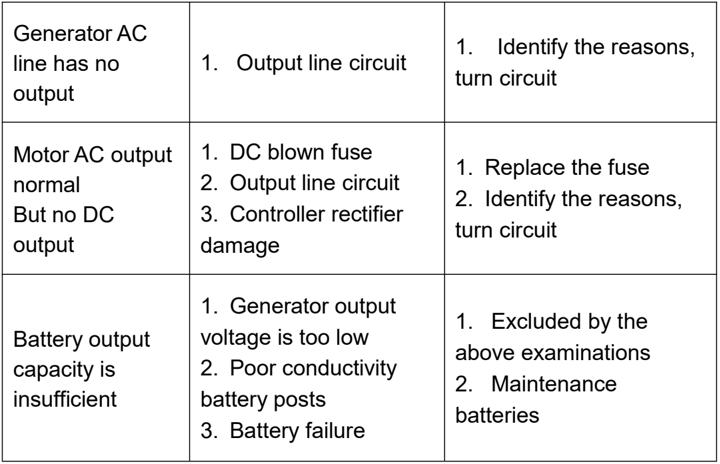
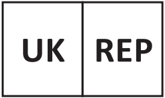
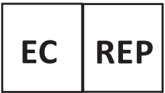
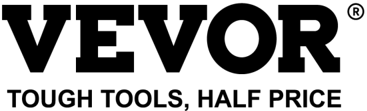

In [30]:
for element, _level in result.document.iterate_items():
   print(element)
   if isinstance(element, PageItem):
        print(
            f" {element.self_ref}:\n{element.annotations}"
        )

PageItem(size=Size(width=419.5, height=595.25), image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=839.0, height=1190.0), uri=AnyUrl('')), page_no=1)
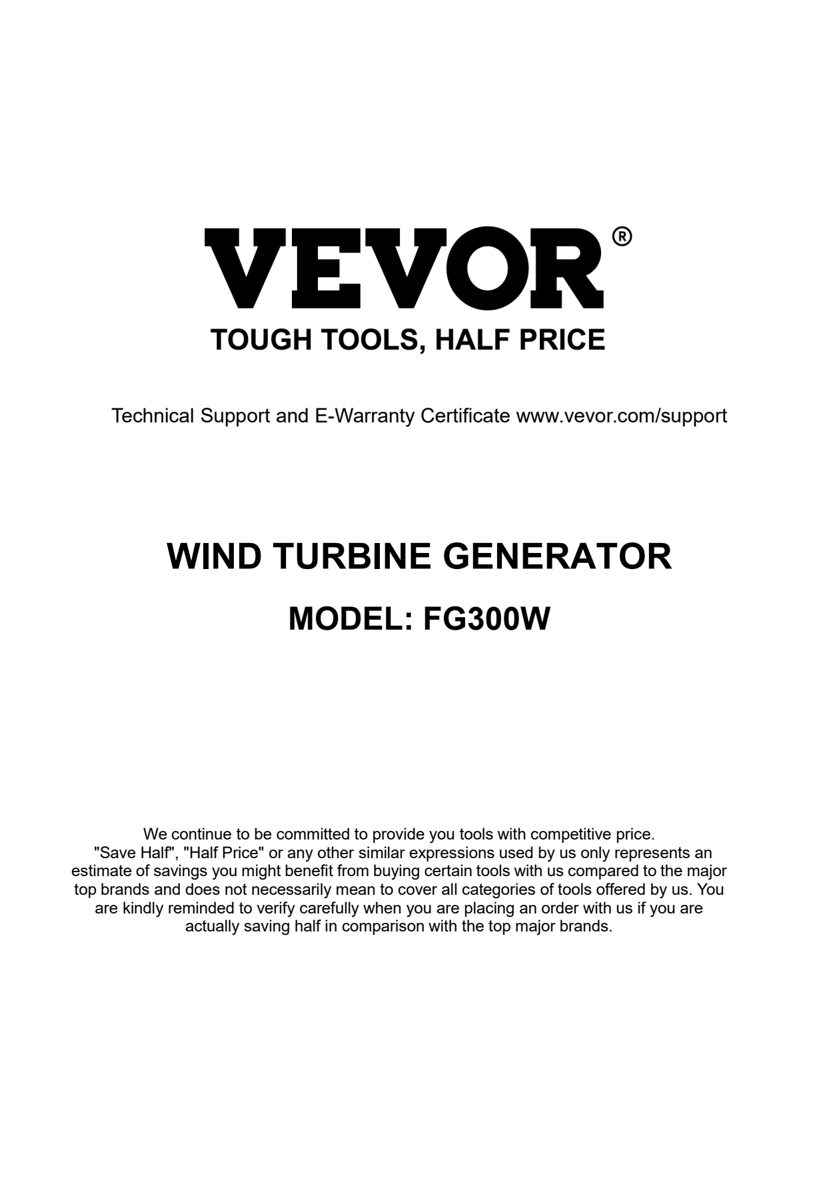

In [32]:
result.document.pages[1]

{'self_ref': '#/pictures/0',
 'parent': {'cref': '#/body'},
 'children': [],
 'content_layer': <ContentLayer.BODY: 'body'>,
 'label': <DocItemLabel.PICTURE: 'picture'>,
 'prov': [{'page_no': 1,
   'bbox': {'l': 101.35415649414062,
    't': 483.56976318359375,
    'r': 317.908935546875,
    'b': 418.9146728515625,
    'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>},
   'charspan': (0, 0)}],
 'captions': [],
 'references': [],
 'footnotes': [],
 'image': {'mimetype': 'image/png',
  'dpi': 144,
  'size': {'width': 433.0, 'height': 130.0},
  'uri': AnyUrl('')},
 'annotations': [{'kind': 'classification',
   'provenance': 'example_classifier-0.0.1',
   'predicted_classes': [{'class_name': 'dummy', 'confidence': 0.42}]},
  {'kind': 'description',
   'text': 'This is a dummy description',
   'provenance': 'a llm model'}]}
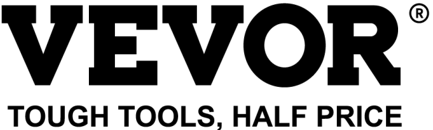

In [27]:
element.model_dump()

In [14]:
converter = DoclingConverterAdapter(
    pdf_input_path,
    output_dir,
    format_options=docling_format_options
    )

docling_document = converter.convert()

2025-02-14 20:33:21,283 - DoclingConverterAdapter - INFO - Converting document


In [15]:
converter.save_document()

2025-02-14 20:33:30,195 - DoclingConverterAdapter - INFO - Saving document


True

In [8]:
docling_document.export_to_markdown()

'| Action Types:    | Inspect, Tighten, Lubricate, Charge, Change/Replace, Regular Service   |\n|------------------|------------------------------------------------------------------------|\n| Equipment / Item | Daily                                                                  |'